<a href="https://colab.research.google.com/github/StevenLevine-NOAA/NBM-Verif/blob/notebooks/NBM_Percentile_vs_Obs_Over_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Obs vs NBM Percentile Time Series**
This python notebook grabs NBM percentile, core deterministic, and obs data for selected variables and sites over a particular county warning area.  
The idea here is to look at verification of a specific event (date/time) and to look at forecasts leading up to that event.  Hopefully, forecasts improve as forecast hour decreases.
If desired, there is an option to look only at longer range forecasts.

Three plotting options are available.  They are in separate cells so you can run or skip any or all.

Option one takes the mean forecast for NBM determinsitic, NBM 10th, 50th and 90th percentile for all obs in the warning area leading up to verification time (forecast hour 00).

Option two plots where the verifying ob lands for each site in NBM percentile space leading up to verification time (forecast hour 00).

Option three plots where the NBM determinsitc forecast lands for each site in NBM percentile space leading up to verification time (forecast hour 00).

 14-March 2023: Added Capability for maximum wind (no determinsitic data available)

*-Steve Levine NWS MDL/SMD 2-Mar-2023*

**IMPORTANT:** These first two cells must be run in the proper before anything else when starting this notebook.  However the only need to be run once.

After running cell 1, you will get a crash message.  You will need to wait a few seconds after it appears, but you can otherwise ignore it and run cell 2.

In [1]:
#@title Initialize Notebook Part 1
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:30
🔁 Restarting kernel...


In [1]:
#@title Initialize Notebook Part 2
!mamba install -q -c conda-forge cartopy contextily pyproj pyepsg pygrib

import numpy as np
from scipy.interpolate import CubicSpline as cs, UnivariateSpline as us
import pandas as pd
from urllib.request import urlretrieve, urlopen
import requests
from datetime import datetime, timedelta
import json
import pygrib
import pyproj
from pyproj import Proj, transform
import os, re, traceback
#from google.colab import runtime

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['font.sans-serif'] = 'Liberation Sans'
matplotlib.rcParams['font.family'] = "sans-serif"
from matplotlib.cm import get_cmap
import seaborn as sns

from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import contextily as cx
import itertools

import warnings
warnings.filterwarnings("ignore")

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


/usr/local/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


**AFTER INITIALIZATION**
The cells above only need to be run once.  Now, you can change the options below and run as many times as you want.  Each run will create new output files.

**NOTE:** "NWS" In network_selection means METAR sites.
use_stageiv only applies when looking at qpf.

"qpf" means qpf24.

In [4]:
#@title Select Forecasts to Verify and Download Ob Data {display-mode: "form"}

element = "maxwind" #@param ["maxt","mint","qpf","maxwind"]
use_stageiv = False #@param {type:"boolean"}
valid_date = "2023-03-14" #@param{type:"date"}
fcst_start = "2023-03-07" #@param{type:"date"}
fcst_end = "2023-03-13" #@param{type:"date"}
region_selection = "CWA" #@param ["WR","SR","ER","CR","CONUS","CWA"]
network_selection="NWS" #@param ["NWS", "RAWS", "NWS+RAWS", "NWS+RAWS+HADS", "ALL", "CUSTOM", "LIST"]
cwa_id="LWX" #@param {type:"string"}
#compare_to="NBM_D" #@param ["NBM_P50", "NBM_D", "MOS"]
nbm_init_hour="12"
export_ob_csv = True #@param {type:"boolean"}
export_df_csv = True #@param {type:"boolean"}

def K_to_F(kelvin):
  fahrenheit = 1.8*(kelvin-273)+32.
  return fahrenheit

def mm_to_in(millimeters):
  inches = millimeters * 0.0393701
  return inches

def mps_to_kts(mps):
  kts = mps * 1.94384
  return kts

fcst_start_date=datetime.strptime(fcst_start,'%Y-%m-%d')
fcst_end_date=datetime.strptime(fcst_end,'%Y-%m-%d')
fcst_valid_date=datetime.strptime(valid_date,'%Y-%m-%d')

if fcst_start_date > fcst_end_date:
  raise Exception("FATAL ERROR: INVALID DATE RANGE (start date is later than end date)")
elif fcst_valid_date <= fcst_end_date:
  raise Exception("FATAL ERROR: INVALID DATE RANGE (Valid date is before forecast end date)")
elif fcst_start_date >= fcst_valid_date:
  raise Exception("FATAL ERROR: INVALID DATE RANGE (Forecast start date is later than valid date)")

#nbm_init = datetime.strptime(nbm_init_date,'%Y-%m-%d') + timedelta(hours=int(nbm_init_hour))

if element == "maxt":
  nbm_core_valid_hour="00"
  nbm_qmd_valid_hour="06"
  valid_date_start = datetime.strptime(valid_date,'%Y-%m-%d')
  valid_date_end = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(days=1)
  obs_start_hour = "1200"
  obs_end_hour = "0600"
  ob_stat = "maximum"
  valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
  rangeOfDays=fcst_valid_date-fcst_start_date
  if rangeOfDays.days > 9:
    print("     ❌ FATAL ERROR: Can only look back up to 9 days for maxT!")
    raise Exception("Based on your entries for fcst_start and valid_date, you are looking back " + str(rangeOfDays.days) + " days.  Aborting...")

elif element == "mint":
  nbm_core_valid_hour="12"
  nbm_qmd_valid_hour="18"
  valid_date_start = datetime.strptime(valid_date,'%Y-%m-%d')
  valid_date_end = datetime.strptime(valid_date,'%Y-%m-%d')
  obs_start_hour = "0000"
  obs_end_hour = "1800"
  ob_stat = "minimum"
  valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
  rangeOfDays=valid_date_start-valid_date_start
  if rangeOfDays.days > 9:
    print("     ❌ FATAL ERROR: Can only look back up to 9 days for minT!")
    raise Exception("Based on your entries for fcst_start and valid_date, you are looking back " + str(rangeOfDays.days) + " days.  Aborting...")

elif element == "qpf":
  nbm_core_valid_hour = "12" #str(qpf_valid_time)
  nbm_valid_hour = "12" #str(qpf_valid_time)
  nbm_qmd_valid_hour="12" #str(qpf_valid_time)
  valid_date = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(hours=12) #timedelta(hours=int(qpf_valid_time))
  valid_date_start = valid_date - timedelta(hours=24)
  valid_date_end = valid_date
  obs_start_hour = "1200" #str(qpf_valid_time)+"00"
  obs_end_hour = "1200" #str(qpf_valid_time)+"00"
  ob_stat = "total"
  valid_end_datetime = valid_date_end 
  rangeOfDays=valid_date_end-valid_date_start
  if rangeOfDays.days > 9:
    print("     ❌ FATAL ERROR: Can only look back up to 9 days for QPF24!")
    raise Exception("Based on your entries for fcst_start and valid_date, you are looking back " + str(rangeOfDays.days) + " days.  Aborting...")
elif element == "maxwind":
  nbm_qmd_valid_hour="06"
  obs_start_hour="0600"
  obs_end_hour="0600"
  ob_stat="maximum"
  valid_date_start = datetime.strptime(valid_date,'%Y-%m-%d')
  valid_date_end = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(days=1)
  valid_end_datetime=valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
  rangeOfDays=valid_date_end-valid_date_start
  if rangeOfDays.days > 9:
    print("     ❌ FATAL ERROR: Can only look back up to 9 days for Maxwind!")
    raise Exception("Based on your entries for fcst_start and valid_date, you are looking back " + str(rangeOfDays.days) + " days.  Aborting...")

#set default website strings
synoptic_token = "ea497aaa40464749b903ac1204fd8020"
statistics_api = "https://api.synopticlabs.org/v2/stations/statistics?"
precipitation_api = "https://api.synopticdata.com/v2/stations/precipitation?"
metadata_api = "https://api.synopticdata.com/v2/stations/metadata?"

# Setup a dictionary for translating a form selection into a something we can pass to mesowest API
network_dict = {"NWS+RAWS+HADS":"&network=1,2,106","NWS+RAWS":"&network=1,2", "NWS":"&network=1", "RAWS": "&network=2", "ALL":""} #, "CUSTOM": "&network="+network_input, "LIST": "&stid="+network_input}
network_string = network_dict[network_selection]

if region_selection == "CONUS":
  region_list = ["WR", "CR", "SR", "ER"]
elif region_selection == "CWA":
  cwa_selection = [cwa_id]
else:
  cwa_selection = [region_selection]

def cwa_list(input_region):
  region_dict={"WR":"BYZ,BOI,LKN,EKA,FGZ,GGW,TFX,VEF,LOX,MFR,MTR,MSO,PDT,PSR,PIH,PQR,REV,STO,SLC,SGX,HNX,SEW,OTX,TWC",
              "CR":"ABR,BIS,CYS,LOT,DVN,BOU,DMX,DTX,DDC,DLH,FGF,GLD,GJT,GRR,GRB,GID,IND,JKL,EAX,ARX,ILX,LMK,MQT,MKX,MPX,LBF,APX,IWX,OAX,PAH,PUB,UNR,RIW,FSD,SGF,LSX,TOP,ICT",
              "ER":"ALY,LWX,BGM,BOX,BUF,BTV,CAR,CTP,RLX,CHS,ILN,CLE,CAE,GSP,MHX,OKX,PHI,PBZ,GYX,RAH,RNK,AKQ,ILM",
              "SR":"ABQ,AMA,FFC,EWX,BMX,BRO,CRP,EPZ,FWD,HGX,HUN,JAN,JAX,KEY,MRX,LCH,LZK,LUB,MLB,MEG,MFL,MOB,MAF,OHX,LIX,OUN,SJT,SHV,TAE,TBW,TSA"}
  if(input_region in ["WR","CR","SR","ER"]):
    cwas_list=region_dict[input_region]
  else:
    cwas_list=input_region
  return cwas_list

def ll_to_index(datalons, datalats, loclon, loclat):
  abslat = np.abs(datalats-loclat)
  abslon = np.abs(datalons-loclon)
  c = np.maximum(abslon, abslat)
  latlon_idx_flat = np.argmin(c)
  latlon_idx = np.unravel_index(latlon_idx_flat, datalons.shape)
  return(latlon_idx)

def project_hrap(lon, lat, s4x, s4y):
  lon = float(lon)
  lat = float(lat)
  
  globe = ccrs.Globe(semimajor_axis=6371200)
  hrap_ccrs = proj = ccrs.Stereographic(central_latitude=90.0,
                          central_longitude=255.0,
                          true_scale_latitude=60.0, globe=globe)
  latlon_ccrs = ccrs.PlateCarree()
  hrap_coords = hrap_ccrs.transform_point(lon,lat,src_crs=latlon_ccrs)
  hrap_idx = ll_to_index(s4x, s4y, hrap_coords[0], hrap_coords[1])

  return hrap_idx

def get_stageiv():
  siv_url = "https://water.weather.gov/precip/downloads/"+valid_date_end.strftime('%Y')+"/"+valid_date_end.strftime('%m')+"/"+valid_date_end.strftime('%d')+"/nws_precip_1day_"+valid_date_end.strftime('%Y%m%d')+"_conus.nc"
  data = urlopen(siv_url).read()
  
  nc = Dataset('data', memory=data)
  #with Dataset(siv_file, 'r') as nc:
  stageIV = nc.variables['observation']
  s4x = nc.variables['x']
  s4y = nc.variables['y']
  return stageIV, s4x, s4y
    

#downlaod/process obs
print('Getting obs...')
obs={}
if os.path.exists("obs"):
  pass
else:
  os.mkdir("obs")
for cwa in cwa_selection:
  json_name="obs/Obs_"+element+"_"+valid_date_start.strftime('%Y%m%d')+obs_start_hour+"_"+valid_date_end.strftime('%Y%m%d')+obs_end_hour+"_"+cwa+".json"
  if os.path.exists(json_name):
    print("Skipping download since JSON obs file already exists")
    pass
  else:
    if element == "mint" or element == "maxt":
      api_token = "&token="+synoptic_token
      station_query = "&cwa="+cwa #cwa_list(region)
      vars_query = "&vars=air_temp"
      start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
      end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
      stat_type = "&type="+ob_stat
      network_query = network_string
      api_extras = "&units=temp%7Cf&within=1440&status=active"
      obs_url = statistics_api + api_token + station_query + vars_query + start_query + end_query + stat_type + network_query + api_extras
    elif element == "maxwind":
      api_token = "&token="+synoptic_token
      station_query = "&cwa="+cwa #cwa_list(region)
      vars_query = "&vars=wind_speed"
      start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
      end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
      stat_type = "&type="+ob_stat
      network_query = network_string
      obs_url = statistics_api + api_token + station_query + vars_query + start_query + end_query + stat_type + network_query
    elif element == "qpf":
      if use_stageiv:
        print("Downloading stage IV data...")
        api_token = "&token="+synoptic_token
        station_query = "&cwa="+cwa #+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation"
        network_query = network_string
        obs_url = metadata_api + api_token + station_query + network_query + api_extras
        stageIV, s4xs, s4ys = get_stageiv()
        print("Meshing stage IV data...")
        s4xs, s4ys = np.meshgrid(s4xs, s4ys)
      else:
        api_token = "&token="+synoptic_token
        station_query = "&cwa="+cwa #+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation&obtimezone=utc"
        network_query = network_string
        vars_query = "&pmode=totals"
        units_query = "&units=precip|in"
        start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
        end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
        obs_url = precipitation_api + api_token + station_query + network_query + vars_query + start_query + end_query + units_query + api_extras
    print("Obs url: " + obs_url)
    urlretrieve(obs_url,json_name)

if os.path.exists(json_name):
  with open(json_name) as json_file:
    obs_json = json.load(json_file)
    print ("Loaded Obs JSON file line 343: " + json_name)
    obs_lats = []
    obs_lons = []
    obs_value = []
    obs_elev = []
    obs_stid = []
    obs_name = []
    for stn in obs_json["STATION"]:
      if stn["STID"] is None:
        stid = "N0N3"
      else:
        stid = stn["STID"]
        name = stn["NAME"]
        if stn["ELEVATION"] and stn["ELEVATION"] is not None:
          elev = stn["ELEVATION"]
        else:
          elev = -999
        lat = stn["LATITUDE"]
        lon = stn["LONGITUDE"]
        if element == "mint" or element == "maxt":
          if 'air_temp_set_1' in stn['STATISTICS'] and stn['STATISTICS']['air_temp_set_1']:
            if ob_stat in stn['STATISTICS']['air_temp_set_1'] and float(stn["LATITUDE"]) != 0.:
              stat = stn['STATISTICS']['air_temp_set_1'][ob_stat]
              obs_stid.append(str(stid))
              obs_name.append(str(name))
              obs_elev.append(int(elev))
              obs_lats.append(float(lat))
              obs_lons.append(float(lon))
              obs_value.append(float(stat))
        elif element == "maxwind":
          if 'wind_speed_set_1' in stn['STATISTICS'] and stn['STATISTICS']['wind_speed_set_1']:
            if ob_stat in stn['STATISTICS']['wind_speed_set_1'] and float(stn["LATITUDE"]) != 0.:
              stat = stn['STATISTICS']['wind_speed_set_1'][ob_stat]
              obs_stid.append(str(stid))
              obs_name.append(str(name))
              obs_elev.append(int(elev))
              obs_lats.append(float(lat))
              obs_lons.append(float(lon))
              obs_value.append(mps_to_kts(float(stat)))
        elif element == "qpf":
          if (stn["STATUS"] == "ACTIVE") and float(stn["LATITUDE"]) < 50.924 and float(stn["LONGITUDE"]) > -125.650 and float(stn["LONGITUDE"]) < -66.008:
            obs_stid.append(str(stid))
            obs_name.append(str(name))
            obs_elev.append(int(elev))
            obs_lats.append(float(lat))
            obs_lons.append(float(lon))
            if use_stageiv:
              coords = project_hrap(lon,lat,s4xs,s4ys)
              siv_value = float(stageIV[coords])
              if (siv_value >+ 0.01):
                obs_value.append(siv_value)
              else:
                obs_value.append(np.NaN)
            else:
              if "precipitation" in stn["OBSERVATIONS"]:
                if "total" in stn["OBSERVATIONS"]["precipitation"][0]:
                  ptotal = stn["OBSERVATIONS"]["precipitation"][0]["total"]
                  if ptotal >= 0.01:
                    obs_value.append(ptotal)
                  else:
                    obs_value.append(np.nan)
                else:
                    obs_value.append(np.nan)
              else:
                obs_value.append(np.nan)
    print("Finished loading JSON obs into dictionary!")
    csv_name="obs_"+element+"_"+cwa+"_"+fcst_valid_date.strftime("%Y%m%d")+".csv"
    obs[cwa] = pd.DataFrame()
    obs[cwa]["stid"] = obs_stid
    obs[cwa]["name"] = obs_name
    obs[cwa]["elevation"] = obs_elev
    obs[cwa]["lat"] = obs_lats
    obs[cwa]["lon"] = obs_lons
    #if element == "maxwind":
    #  obs[cwa]["ob_"+element] = mps_to_kts(obs_value)
    #else:
  obs[cwa]["ob_"+element] = obs_value
  if export_ob_csv is True:
    obs[cwa].to_csv(csv_name)
    print("Written Obs CSV file: " + csv_name)
        


Getting obs...
Skipping download since JSON obs file already exists
Loaded Obs JSON file line 343: obs/Obs_maxwind_202303140600_202303150600_LWX.json
Finished loading JSON obs into dictionary!
Written Obs CSV file: obs_maxwind_LWX_20230314.csv


Now, we download the relevant NBM data.  Files come from the AWS 'big data' NOAA server.

Note that this section will have to be re-run whenever the above cell is re-run.

In [ ]:
#@title Download Forecast Data and Match with Obs

def ll_to_index(datalons, datalats, loclon, loclat):
  abslat = np.abs(datalats-loclat)
  abslon = np.abs(datalons-loclon)
  c = np.maximum(abslon, abslat)
  latlon_idx_flat = np.argmin(c)
  latlon_idx = np.unravel_index(latlon_idx_flat, datalons.shape)
  return(latlon_idx)

def find_roots(x,y):
  s = np.abs(np.diff(np.sign(y))).astype(bool)
  return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

def download_subset(remote_url, remote_file, local_filename):
  print("   > Downloading a subset of NBM gribs")
  if os.path.exists("nbm"):
    pass
  else:
    os.mkdir("nbm")
  local_file = "nbm/"+local_filename
  if "qmd" in remote_file:
    if element == "maxt":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day max fcst:'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'
    elif element == "mint":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day min fcst:'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour min fcst:'
    elif element == "maxwind":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 == 0):
        search_string = f':WIND:10 m above ground:{str(int(nbm_qmd_forecasthour_start/24))}-{str(int(nbm_qmd_forecasthour/24))} hour max fcst:'
      else:
        search_string = f':WIND:10 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'
    elif element == "qpf":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':APCP:surface:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day acc fcst:'
      else:
        search_string = f':APCP:surface:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour acc fcst:'
  elif "core" in remote_file:
    if element == "maxt":
      search_string = f':TMAX:2 m above ground:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour max fcst:'
    elif element == "mint":
      search_string = f':TMIN:2 m above ground:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour min fcst:'
  #print(search_string)
  idx = remote_url+".idx"
  r = requests.get(idx)
  if not r.ok: 
    print('     ❌ SORRY! Status Code:', r.status_code, r.reason)
    print(f'      ❌ It does not look like the index file exists: {idx}')

  lines = r.text.split('\n')
  expr = re.compile(search_string)
  byte_ranges = {}
  for n, line in enumerate(lines, start=1):
      # n is the line number (starting from 1) so that when we call for 
      # `lines[n]` it will give us the next line. (Clear as mud??)

      # Use the compiled regular expression to search the line
      if expr.search(line):   
          # aka, if the line contains the string we are looking for...

          # Get the beginning byte in the line we found
          parts = line.split(':')
          rangestart = int(parts[1])

          # Get the beginning byte in the next line...
          if n+1 < len(lines):
              # ...if there is a next line
              parts = lines[n].split(':')
              rangeend = int(parts[1])
          else:
              # ...if there isn't a next line, then go to the end of the file.
              rangeend = ''

          # Store the byte-range string in our dictionary, 
          # and keep the line information too so we can refer back to it.
          byte_ranges[f'{rangestart}-{rangeend}'] = line
          #print(line)
  for i, (byteRange, line) in enumerate(byte_ranges.items()):
        
        if i == 0:
            # If we are working on the first item, overwrite the existing file.
            curl = f'curl -s --range {byteRange} {remote_url} > {local_file}'
        else:
            # If we are working on not the first item, append the existing file.
            curl = f'curl -s --range {byteRange} {remote_url} >> {local_file}'
        try:    
          num, byte, date, var, level, forecast, _ = line.split(':')
        except:
          pass
        
        #print(f'  Downloading GRIB line [{num:>3}]: variable={var}, level={level}, forecast={forecast}')    
        os.system(curl)
    
  if os.path.exists(local_file):
      print(f'      ✅ Success! Searched for [{search_string}] and got [{len(byte_ranges)}] GRIB fields and saved as {local_file}')
      return local_file
  else:
      print(print(f'      ❌ Unsuccessful! Searched for [{search_string}] and did not find anything!'))


def daterange(start_date,end_date):
  for n in range(int((end_date - start_date).days) + 1):
    yield start_date + timedelta(n)

fcst={} #fcst is dictionary of dataframes by cwa, much like obs
masterfcst=pd.DataFrame() #to concatenate to

if element == "maxwind":
  fcst_stop_date=fcst_end_date-timedelta(hours=24) #prevent sub-24 hour forecast from being looked for
else:
  fcst_stop_date=fcst_end_date

for nbmdate in daterange(fcst_start_date,fcst_stop_date):
    nbm_init=nbmdate + timedelta(hours=12)
    #print("Pulling determinisitc data for: " + nbm_init)
    if element == "mint" or element == "maxt":
      nbm_core_valid_end_datetime = fcst_valid_date + timedelta(hours=int(nbm_core_valid_hour)+24)
      nbm_qmd_valid_end_datetime = fcst_valid_date + timedelta(hours=int(nbm_qmd_valid_hour)+24)
      core_init = nbm_init + timedelta(hours = 7)
      nbm_core_fhdelta = nbm_core_valid_end_datetime - core_init
      nbm_core_forecasthour = nbm_core_fhdelta.total_seconds() / 3600.
      nbm_core_forecasthour_start = nbm_core_forecasthour - 12
    elif element == "qpf":
      core_init = nbm_init
      nbm_core_valid_end_datetime = fcst_valid_date + timedelta(hours=int(nbm_core_valid_hour))
      nbm_qmd_valid_end_datetime = fcst_valid_date + timedelta(hours=int(nbm_qmd_valid_hour))
      nbm_core_fhdelta = nbm_core_valid_end_datetime - nbm_init
      nbm_core_forecasthour = nbm_core_fhdelta.total_seconds() / 3600.
      nbm_core_forecasthour_start = nbm_core_forecasthour - 12
    elif element == "maxwind":
      #adding core valid times here to help out with plotting later
      #They are dummy values as there is no determinsitic data for max wind
      nbm_qmd_valid_end_datetime = fcst_valid_date + timedelta(hours=int(nbm_qmd_valid_hour))
      nbm_core_valid_end_datetime = nbm_qmd_valid_end_datetime - timedelta(hours=12)
      nbm_qmd_fhdelta = nbm_qmd_valid_end_datetime - nbm_init
      nbm_core_fhdelta = nbm_core_valid_end_datetime - nbm_init
      nbm_qmd_forecasthour = nbm_qmd_fhdelta.total_seconds() / 3600.
      nbm_core_forecasthour = nbm_core_fhdelta.total_seconds() / 3600.
    nbm_qmd_fhdelta = nbm_qmd_valid_end_datetime - nbm_init
    nbm_qmd_forecasthour = nbm_qmd_fhdelta.total_seconds() / 3600.
    if element == "qpf" or element == "maxwind":
      nbm_qmd_forecasthour_start = nbm_qmd_forecasthour - 24
    else:
      nbm_qmd_forecasthour_start = nbm_qmd_forecasthour - 18
    #get file names 
    nbm_init_filen = nbm_init.strftime('%Y%m%d') + "_" + nbm_init.strftime('%H')
    nbm_url_base = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+nbm_init.strftime('%Y%m%d') \
                +"/"+nbm_init.strftime('%H')+"/"
    if element != "maxwind":
      print("Pulling determinstic data for hour: " + str(nbm_core_forecasthour))
      nbm_init_filen_core = core_init.strftime('%Y%m%d') + "_" + core_init.strftime('%H')
      nbm_url_base_core = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+core_init.strftime('%Y%m%d') \
                  +"/"+core_init.strftime('%H')+"/"
      temp_vars = ["maxt","mint"]
      if (element == "qpf"):
        detr_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.co.grib2'
        detr_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.co.{element}_subset.grib2'
        if (int(nbm_qmd_forecasthour) < 12):
          break
        detr_url = nbm_url_base+"qmd/"+detr_file

      elif any(te in element for te in temp_vars):
        detr_file = f"blend.t{int(core_init.strftime('%H')):02}z.core.f{int(nbm_core_forecasthour):03}.co.grib2"
        detr_file_subset = f"blend.t{int(core_init.strftime('%H')):02}z.core.{nbm_init_filen_core}f{int(nbm_core_forecasthour):03}.co.{element}_subset.grib2"
        if (int(nbm_core_forecasthour) < 12):
          break
        detr_url = nbm_url_base_core+"core/"+detr_file
      
      #download file if we don't have it yet
      if os.path.exists("nbm/"+detr_file_subset):
        print("   > NBM deterministic already exists")
      else:
        print("   > Getting NBM deterministic")
        if os.path.exists("nbm"):
          pass
        else:
          os.mkdir("nbm")
      #urlretrieve(detr_url, "nbm/"+detr_file)
      download_subset(detr_url, detr_file, detr_file_subset)
      #extract deterministic values
      nbmd = pygrib.open("nbm/"+detr_file_subset)
      if element == "maxt":
        deterministic = nbmd.select(name="Maximum temperature",lengthOfTimeRange=12, stepTypeInternal="max")[0]
        deterministic_array = K_to_F(deterministic.values)
      elif element == "mint":
        deterministic = nbmd.select(name="Minimum temperature",lengthOfTimeRange=12, stepTypeInternal="min")[0]
        deterministic_array = K_to_F(deterministic.values)
      elif element == "qpf":
        deterministic = nbmd.select(name="Total Precipitation",lengthOfTimeRange=24)[-1]
        deterministic_array = mm_to_in(deterministic.values)
      nbmlats, nbmlons = deterministic.latlons()
      nbmd.close()

      for cwa in cwa_selection:
        fcst[cwa] = pd.DataFrame()
        point_lats = obs[cwa]["lat"].values
        point_lons = obs[cwa]["lon"].values
        stations = obs[cwa]["stid"].values
        obvals = obs[cwa]["ob_"+element].values
        fcsthrs=np.full(len(stations),nbm_core_forecasthour)
        detr_values = []
        nbm_fidx = []
      #if element == "maxwind":
        #detr_values=np.empty(np.shape(stations))
        #detr_values.fill(np.nan)
        #for i in range(0,len(point_lats)):
        #  coords = ll_to_index(nbmlons,nbmlats,point_lons[i],point_lats[i])
        #  nbm_fidx.append(coords)
      #else:
        for i in range(0, len(point_lats)):
          coords = ll_to_index(nbmlons,nbmlats,point_lons[i],point_lats[i])
          nbm_fidx.append(coords)
          detr_value = deterministic_array[coords]
          detr_values.append(detr_value)
        fcst[cwa]["stid"] = stations
        fcst[cwa]["NBM_fidx"] = nbm_fidx
        fcst[cwa]["NBM_D"] = detr_values
        fcst[cwa]["forecast_hour"] = fcsthrs
        fcst[cwa]["OB"] = obvals
    else: #for maxwind (no deterministic available)
      print("MAXWIND: Putting stations locations into dataframe")
      for cwa in cwa_selection:
        fcst[cwa] = pd.DataFrame()
        point_lats = obs[cwa]["lat"].values
        point_lons = obs[cwa]["lon"].values
        stations = obs[cwa]["stid"]
        obvals = obs[cwa]["ob_"+element].values
        nbm_fidx = []
        nbmlats = None
        nbmlons = None
        fcsthrs=np.full(len(stations),nbm_core_forecasthour)
        detr_values=np.empty(np.shape(stations))
        detr_values.fill(np.nan)
        fcst[cwa]["stid"] = stations
        fcst[cwa]["NBM_D"] = detr_values
        fcst[cwa]["forecast_hour"] = fcsthrs
        fcst[cwa]["OB"] = obvals

    perc_list = [1,5,10,20,30,40,50,60,70,80,90,95,99]
    perc_dict = {"maxt":"maxt18p", "mint":"mint18p", "qpf":"qpf24p"}
    perc_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.co.grib2'
    perc_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.co.{element}_subset.grib2'
    perc_url = nbm_url_base+"qmd/"+perc_file
    print("  >> perc_url = " + perc_url)
    print("  >> perc_file_subset = " + perc_file_subset)
    if os.path.exists("nbm/"+perc_file_subset):
      print("   > NBM probabilistic already exists")
    else:
      #urlretrieve(perc_url, "nbm/"+perc_file)
      print("   > Getting NBM probabilistic")
      download_subset(perc_url, perc_file, perc_file_subset)

    nbmperc = pygrib.open("nbm/"+perc_file_subset)
    print('   > Extracting NBM Probabilistic')
    #load percentile data
    for perc in perc_list:
      print(f'     >> Extracting NBM P{int(perc):01}')
      perc_name = "NBM_P"+str(perc)
      if element == "maxt":
        percdata = K_to_F(nbmperc.select(name="2 metre temperature", stepTypeInternal="max", percentileValue=perc)[0].values)
      elif element == "mint":
        percdata = K_to_F(nbmperc.select(name="2 metre temperature", stepTypeInternal="min", percentileValue=perc)[0].values)
      elif element == "qpf":
        percdata = mm_to_in(nbmperc.select(name="Total Precipitation",lengthOfTimeRange=24, percentileValue=perc)[0].values)
      elif element == "maxwind":
        percinv = nbmperc.select(name="10 metre wind speed",lengthOfTimeRange=24,stepTypeInternal="max",percentileValue=perc)[0]
        percdata=mps_to_kts(percinv.values)

      #get and load ob i/j points for maxwind obs (if not already defined from core/deterministic or previous file)
      if nbmlats is None:
        nbmlats,nbmlons=percinv.latlons()
        for i in range(0,len(point_lats)):
          coords = ll_to_index(nbmlons,nbmlats,point_lons[i],point_lats[i])
          nbm_fidx.append(coords)
        fcst[cwa]["NBM_fidx"] = nbm_fidx
      
      #now run the percentile calculations
      for cwa in cwa_selection:
        nbm_coords = fcst[cwa]["NBM_fidx"].values
        perc_values = []
        for i in range(0, len(nbm_coords)):
          perc_value = percdata[nbm_coords[i]]
          perc_values.append(perc_value)
        fcst[cwa][perc_name] = perc_values
    nbmperc.close()
    print('Creating point distribution curves and interpolating...')
    for cwa in cwa_selection:
      perc_start = fcst[cwa].columns.get_loc("NBM_P1")
      perc_end = fcst[cwa].columns.get_loc("NBM_P99")
      all_percs = fcst[cwa].iloc[:, perc_start:perc_end+1].values
      var_string = "ob_"+element
      all_obs = obs[cwa][[var_string]].values
      all_nbmd = fcst[cwa][['NBM_D']].values
      obs_percs = []
      nbmd_percs = []
      mos_percs = []
      for i in range(0,len(all_obs)):
        udf = us(perc_list, all_percs[i,:], bbox=[0,100], ext=0)
        if np.isnan(all_obs[i]):
          ob_perc = np.nan
        elif all_obs[i] <= udf(0):
          ob_perc = -10
        elif all_obs[i] >= udf(100):
          ob_perc = 110
        else:
          ob_perc = find_roots(np.arange(0,101,1), udf(np.arange(0,101,1)) - all_obs[i])
          ob_perc = ob_perc[0].round(1)

        if np.isnan(all_nbmd[i]):
          nbm_perc = np.nan
        elif all_nbmd[i] <= udf(0):
          nbm_perc = -10
        elif all_nbmd[i] >= udf(100):
          nbm_perc = 110
        else:
          nbm_perc = find_roots(np.arange(0,101,1), udf(np.arange(0,101,1)) - all_nbmd[i])
          nbm_perc = nbm_perc[0].round(1)

        if np.isnan(ob_perc):
          obs_percs.append(ob_perc)
        else:
          obs_percs.append(int(ob_perc))
        if np.isnan(nbm_perc):
          nbmd_percs.append(nbm_perc)
        else:  
          nbmd_percs.append(int(nbm_perc))    
      fcsthrs=np.full(len(nbmd_percs),nbm_core_forecasthour)
      fcst[cwa]["ob_perc"] = obs_percs
      fcst[cwa]["NBMd_perc"] = nbmd_percs
      fcst[cwa]["forecast_hour"] = fcsthrs
      tmpframe=pd.concat([masterfcst,fcst[cwa]])
      masterfcst=tmpframe
masterfcst.replace(-9999.0,np.nan)

if export_df_csv:
  csv_name="obs_"+element+"_series_valid_"+valid_end_datetime.strftime('%Y%m%d')+"_"+cwa+".csv"
  masterfcst.to_csv(csv_name,na_rep="MISSING")
  print("  >  Created and saved:" + csv_name)

MAXWIND: Putting stations locations into dataframe
  >> perc_url = https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend.20230307/12/qmd/blend.t12z.qmd.f162.co.grib2
  >> perc_file_subset = blend.t12z.qmd.20230307_1220230307_12f162.co.maxwind_subset.grib2
   > Getting NBM probabilistic
   > Downloading a subset of NBM gribs
      ✅ Success! Searched for [:WIND:10 m above ground:138-162 hour max fcst:] and got [106] GRIB fields and saved as nbm/blend.t12z.qmd.20230307_1220230307_12f162.co.maxwind_subset.grib2
   > Extracting NBM Probabilistic
     >> Extracting NBM P1
     >> Extracting NBM P5
     >> Extracting NBM P10
     >> Extracting NBM P20
     >> Extracting NBM P30
     >> Extracting NBM P40
     >> Extracting NBM P50
     >> Extracting NBM P60
     >> Extracting NBM P70
     >> Extracting NBM P80
     >> Extracting NBM P90
     >> Extracting NBM P95
     >> Extracting NBM P99
Creating point distribution curves and interpolating...
MAXWIND: Putting stations locations into dataframe


In [ ]:
#@title Plotting Option One - Averaged Forecasts Over Domain
masterfcst=masterfcst.replace(-9999.0,np.NaN)
units={"maxt":"deg F", "mint":"deg F", "qpf":"in", "maxwind":"kts"}
fig=plt.figure(constrained_layout=False,figsize=(22,16),dpi=80)
grid=fig.add_gridspec(1,1)
ax=fig.add_subplot(1,1,1)
mosframe=masterfcst.groupby(['forecast_hour'])[['forecast_hour','OB','NBM_D','NBM_P10','NBM_P50','NBM_P90']].mean()
plt.axhline(mosframe.loc[mosframe.index[0],'OB'],color='black',linewidth=4,linestyle='dashed',label="OB")
for var in ['NBM_P10','NBM_P50','NBM_P90']:
  mosframe.plot(ax=ax,kind="line",x="forecast_hour",y=var,grid=True,marker='o',markersize=3,fontsize=18,linewidth=2)
if element != "maxwind":
  mosframe.plot(ax=ax,kind="line",x="forecast_hour",y='NBM_D',grid=True,marker='o',markersize=3,fontsize=18,linewidth=2)
ax.legend(loc='lower center',bbox_to_anchor=[0.5,1.00],fancybox=True,shadow=True,ncol=6,prop={'size': 18})
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel("Forecast Hour",fontsize=26)
plt.ylabel("Forecast Value " + units[element],fontsize=26)
title_string="Time Series of Mean Forecast and Obs of " + element + " valid at " + valid_date_start.strftime('%m/%d/%y')  + " over WFO " + cwa
fig.text(0.5,0.94,title_string,horizontalalignment='center',verticalalignment='bottom',weight='bold',fontsize=26)
fig.savefig(cwa+"_"+element+"_mean_valid_" + valid_date_start.strftime('%m%d%y')+".png")

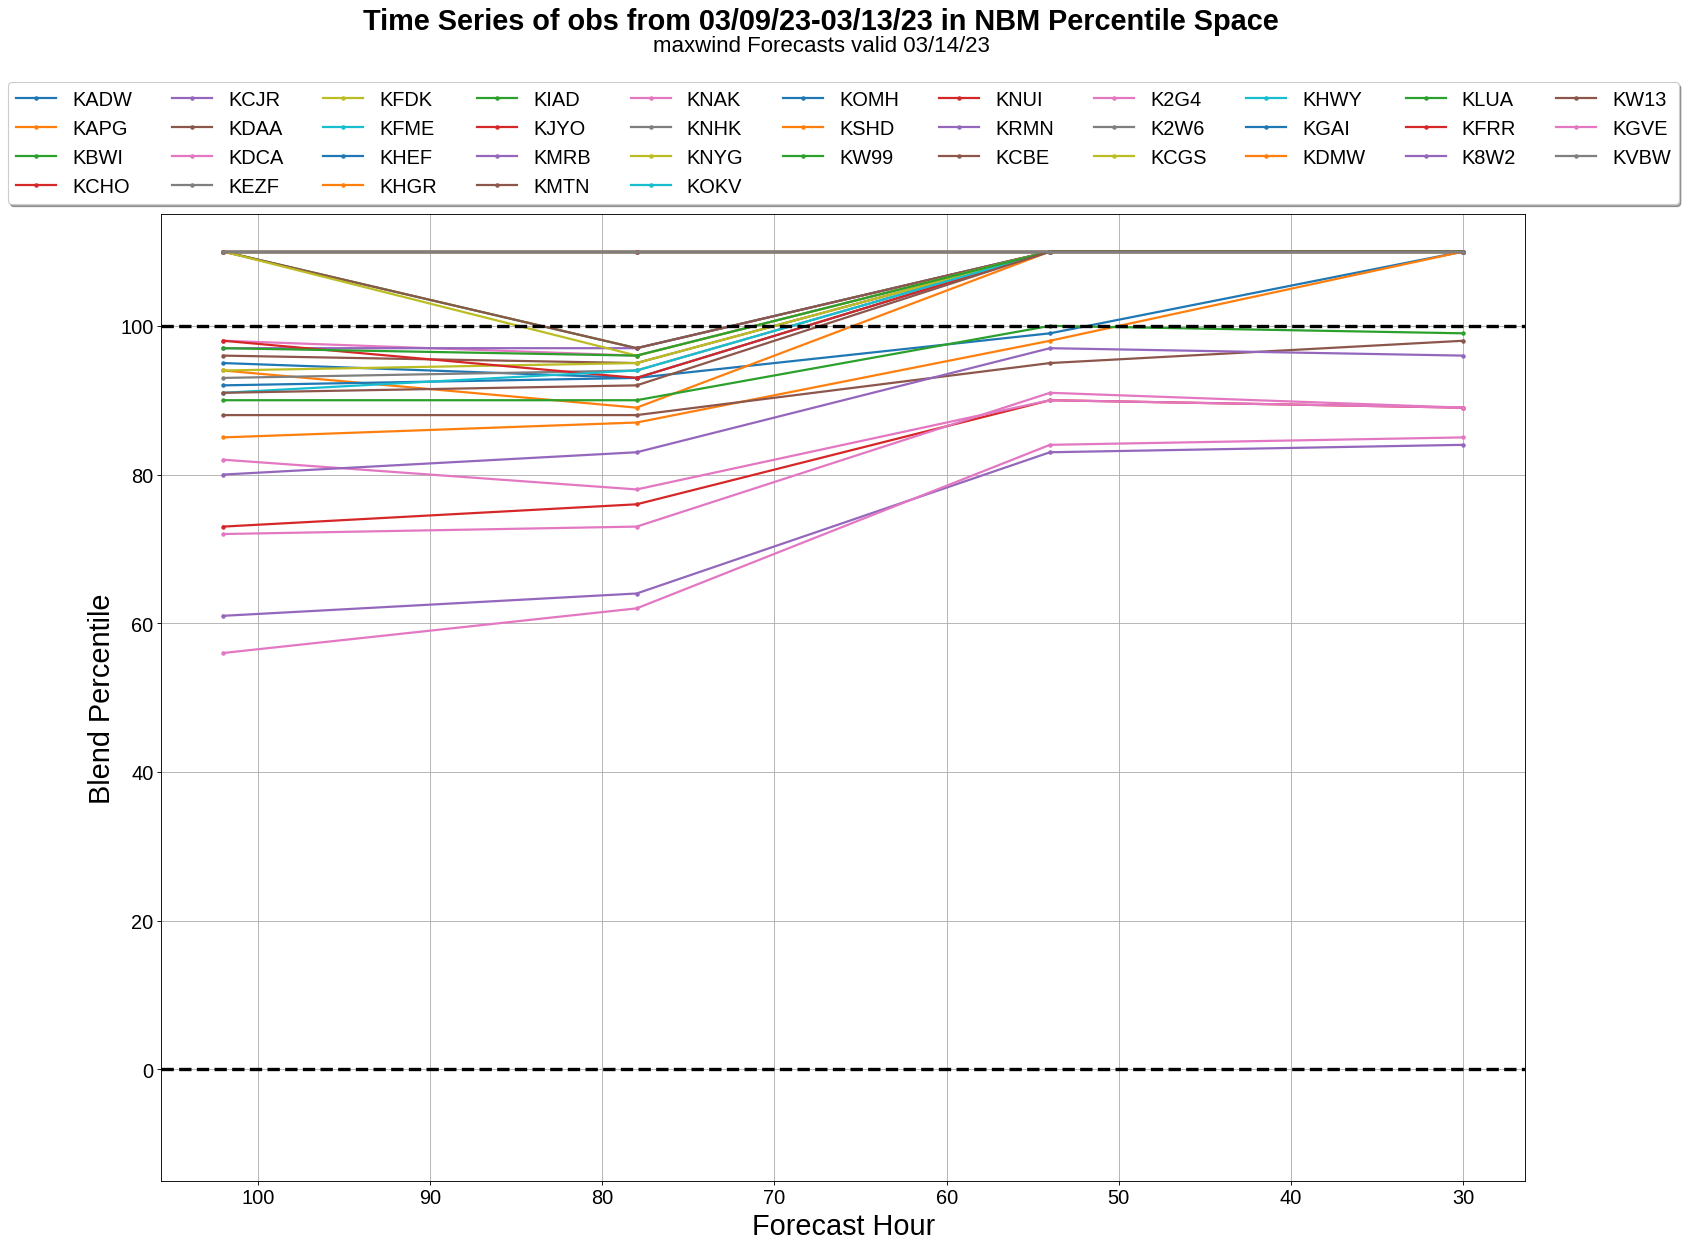

In [9]:
#@title Plotting Option Two - Obs in Percentile Space Over Time
#generate time series plot
fig=plt.figure(constrained_layout=False,figsize=(22,16),dpi=80)
grid=fig.add_gridspec(1,1)
ax=fig.add_subplot(1,1,1)
#combine obs and forecast dataframes into one
for cwa in cwa_selection:
  allvals=pd.merge(masterfcst,obs[cwa],on='stid')
allvals.to_csv(cwa+'_'+element+'ob_percentiles_valid_'+valid_date_start.strftime('%m%d%y')+'.csv')
fcvals = pd.unique(allvals['forecast_hour'])
for stn in pd.unique(allvals['stid']):
  stnframe=allvals.loc[allvals['stid'] == stn]
  stnframe.plot(ax=ax,x="forecast_hour",y="ob_perc",label=stn,xlabel="Forecast Hour",ylabel="Percentile",ylim=(-15,115),grid=True,marker='o',markersize=3,linewidth=2,fontsize=18)
ax.legend(loc='lower center',bbox_to_anchor=[0.5,1.00],fancybox=True,shadow=True,ncol=11,prop={'size': 18})
ax.set_xlim(ax.get_xlim()[::-1])
title_string="Time Series of obs from " + fcst_start_date.strftime('%m/%d/%y')+ "-" + fcst_end_date.strftime('%m/%d/%y') + " in NBM Percentile Space"
sub_string=element + " Forecasts valid " + valid_date_start.strftime('%m/%d/%y')
#ax.set_title(title_string+'\n'+sub_string)
plt.axhline(0,color='black',linewidth=3,linestyle='dashed')
plt.axhline(100,color='black',linewidth=3,linestyle='dashed')
plt.xlabel("Forecast Hour",fontsize=26)
plt.ylabel("Blend Percentile",fontsize=26)
fig.text(0.5,1.02,title_string,horizontalalignment='center',verticalalignment='bottom',weight='bold',fontsize=26)
fig.text(0.5,1.02,sub_string,horizontalalignment='center',verticalalignment='top',fontsize=20)
fig.savefig(cwa+'_'+element+'_ob_pctplot_bystn_valid_'+valid_date_start.strftime('%m%d%y')+".png") #,bbox_inches='tight')

In [ ]:
#@title Plotting Option Three - NBM-D in Percentile Space
#generate time series plot
if element == "maxwind":
  raise Exception("FATAL ERROR: No deterministic data available for maxwind")
fig=plt.figure(constrained_layout=False,figsize=(22,16),dpi=80)
grid=fig.add_gridspec(1,1)
ax=fig.add_subplot(1,1,1)
#combine obs and forecast dataframes into one
for cwa in cwa_selection:
  allvals=pd.merge(masterfcst,obs[cwa],on='stid')
allvals.to_csv(cwa+'_'+element+'nbmd_percentiles_valid_'+valid_date_start.strftime('%m%d%y')+'.csv')
fcvals = pd.unique(allvals['forecast_hour'])
for stn in pd.unique(allvals['stid']):
  stnframe=allvals.loc[allvals['stid'] == stn]
  stnframe.plot(ax=ax,x="forecast_hour",y="NBMd_perc",label=stn,xlabel="Forecast Hour",ylabel="Percentile",ylim=(-15,115),grid=True,marker='o',markersize=3,linewidth=2,fontsize=18)
ax.legend(loc='lower center',bbox_to_anchor=[0.5,1.00],fancybox=True,shadow=True,ncol=11,prop={'size': 18})
ax.set_xlim(ax.get_xlim()[::-1])
title_string="Time Series of Deterministic NBM from " + fcst_start_date.strftime('%m/%d/%y')+ "-" + fcst_end_date.strftime('%m/%d/%y') + " in NBM Percentile Space"
sub_string=element + " Forecasts valid " + valid_date_start.strftime('%m/%d/%y')
#ax.set_title(title_string+'\n'+sub_string)
plt.axhline(0,color='black',linewidth=3,linestyle='dashed')
plt.axhline(100,color='black',linewidth=3,linestyle='dashed')
plt.xlabel("Forecast Hour",fontsize=26)
plt.ylabel("Blend Percentile",fontsize=26)
fig.text(0.5,1.02,title_string,horizontalalignment='center',verticalalignment='bottom',weight='bold',fontsize=26)
fig.text(0.5,1.02,sub_string,horizontalalignment='center',verticalalignment='top',fontsize=20)
fig.savefig(cwa+'_'+element+'_nbmd_pctplot_bystn_valid_'+valid_date_start.strftime('%m%d%y')+".png") #,bbox_inches='tight')